In [2]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import torch
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)

from datasets import dataset_utils
from datasets import sequence_aggregator
from explainability_analysis.visualization_functions import * 
from explainability_analysis.transformer_analysis import *
from explainability_analysis.crop_spectral_signature_analysis import * 
from explainability_analysis.classification_results_summarizer import * 
from explainability_analysis.visualization_constants import *

plt.rcParams.update(poster_fonts)

figures_base_path = os.path.join(FIGURES_BASE_PATH, "attention_key_dates_selector")

num_classes = 12
max_sequence_length = 144

def get_used_dates_for_model_results(num_dates_used, accuracy_per_top_n_dates, avg_attention_per_obs_acq_date_orig_model):
    
    result_dfs = []
    for num_dates in num_dates_used:
        dates_used = list(avg_attention_per_obs_acq_date_orig_model.reset_index().iloc[0:num_dates]["Date"].values)
        accuracy = accuracy_per_top_n_dates.loc[accuracy_per_top_n_dates["Num. dates"] == num_dates]["Class accuracy"].values[0]
        dates_with_accuracy = {
            "Date": dates_used,
            "Class accuracy": [accuracy] * len(dates_used),
            "Num. dates": [num_dates] * len(dates_used)}
        result_dfs.append(pd.DataFrame(dates_with_accuracy))
        
    return pd.concat(result_dfs, ignore_index=True).sort_values(by="Date")

C:\Users\Ivica Obadic\PycharmProjects\EOExplainability


In [20]:
dataset_folder = "C:/Users/datasets/BavarianCrops/"
model_root_path = "C:/Users/results/crop-type-classification-explainability/"
temporal_attn_weights, avg_attention_per_obs_acq_date = get_temporal_attn_weights(model_root_path, "all_dates", "1654184128")
model_full_path = get_model_path(None, "all_dates", "1654184128", model_root_path, False)
avg_attention_per_obs_acq_date.to_csv(os.path.join(model_full_path, "key_attention_dates.csv"))

Reading the precomputed attention weights from C:/Users/results/crop-type-classification-explainability//12_classes/right_padding/obs_aq_date/layers=1,heads=1,emb_dim=128/all_dates\1654184128\predictions\attn_weights\postprocessed\parcel_temporal_attention.csv


In [ ]:
accuracy_per_top_n_dates = pd.read_csv(os.path.join(model_root_path, "num_dates_accuracy_results.csv"), index_col=0)
accuracy_per_top_n_dates["Num. dates"] = accuracy_per_top_n_dates["Num. dates"].astype(int)
accuracy_model_all_dates = read_classification_results(model_root_path)

avg_attention_per_obs_acq_date_orig_model = sort_obs_acq_dates_by_attention(model_root_path)
avg_attention_per_obs_acq_date_orig_model

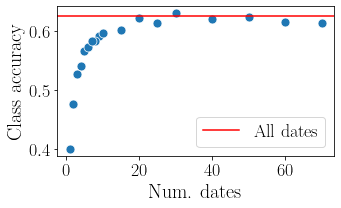

In [16]:
fig_dim = set_size(350)
fig, axs = plt.subplots(figsize=(fig_dim[0], 2.5))

axs = sns.scatterplot(data=accuracy_per_top_n_dates, x="Num. dates", y="Class accuracy", s=80)

axs.axhline(accuracy_model_all_dates[0], c='red', label="All dates")

legend_handles = axs.get_legend_handles_labels()
axs.legend(loc = 4)

fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, 'accuracy_vs_num_attn_key_dates.pdf'))

In [ ]:
fig = px.scatter(
    accuracy_per_top_n_dates,
    x="Num. dates",
    y='Class accuracy')

original_model_results_x = np.arange(min(accuracy_per_top_n_dates["Num. dates"]),
                                     max(accuracy_per_top_n_dates["Num. dates"])+1,
                                    step=1)
y = [accuracy_model_all_dates[0]] * len(original_model_results_x)
fig.add_trace(go.Scatter(x=original_model_results_x,
                         y=y, 
                         mode='lines', 
                         line=dict(color='red', width=2),
                         name='All dates'))
# fig.add_hline(y=original_model_result[0], line_color="red", annotation_text="All dates",
#               annotation_position="top left")
fig.update_layout(
    margin=dict(l=5, r=5, t=5, b=5),
    showlegend = True,
    font_family="Serif",
    font_size=14,
    width=300,
    height=250,
    legend=dict(
        #yanchor="top",
        y=0.8,
        xanchor="right"))
fig.show()
fig.write_image(os.path.join(figures_base_path, "accuracy_vs_num_attn_key_dates.pdf"))

In [ ]:
accuracy_per_top_n_dates.loc[accuracy_per_top_n_dates["Num. dates"] == 1]["Class accuracy"] / accuracy_model_all_dates[0]

In [ ]:
dates_and_accuracy_results = get_used_dates_for_model_results([1, 2, 3, 5, 10, 20], accuracy_per_top_n_dates, avg_attention_per_obs_acq_date_orig_model)
fig = px.scatter(
    dates_and_accuracy_results,
    x="Date",
    y='Class accuracy',
    color="Num. dates")
fig.update_layout(
    margin=dict(l=5, r=5, t=5, b=5),
    showlegend = True,
    font_family="Serif",
    font_size=14,
    width=300,
    height=250,
    legend=dict(
        #yanchor="top",
        x=0.1,
        xanchor="left"))
fig.show()
fig.write_image(os.path.join(figures_base_path, "key_dates_visualization.pdf"))